In [40]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import contextily as cx
import warnings
from sklearn import preprocessing
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
import spreg 
import statsmodels.formula.api as smf
from spreg import ML_Lag, ML_Error, GM_Lag
import libpysal
from scipy import stats
import esda
from esda.moran import Moran

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

data_dir = "C:/Users/mmh/OneDrive - Oak Ridge National Laboratory/Melrose/9.Data/"
map_dir = "C:/Users/mmh/OneDrive - Oak Ridge National Laboratory/Melrose/8.Maps/"

%store -r z_tract
%store -r inp
inp = inp.dropna()
print(len(inp))
inp.head(2)

1422


,ZCTA5,ev_rate,White_prop,Elderly_prop,NumStation_10,Bachelor_prop,Rent_prop,Zero_veh_prop,D1A,D1B,D1C,D1C5_RET,D1C5_OFF,D3AAO,D3APO,D2B_E5MIX,D2A_EPHHM,D4A,D4D,D5AR,D5BR,h_ami,t_ami,ev_rate_adj,Rent_Near_Emp,geometry
0,12007,0.000000,100.000000,30.592105,0.653407,10.958904,12.598425,5.511811,88.761563,157.043620,27.067595,1.793343,5.480141,0.517611,6.506853,0.712806,0.487343,653.697143,4450.470212,451218.428571,11.024204,33.5,16.0,0.000000,69.041143,"POLYGON ((-73.94111 42.45438, -73.94109 42.454..."
1,12009,9.493671,87.741244,19.359066,2.717592,51.955885,19.619680,2.821814,0.084824,0.190405,0.075117,0.001792,0.004505,0.265703,1.718405,0.753436,0.636400,1207.000000,0.000000,20786.666667,0.000000,34.0,24.0,2.168356,0.088390,"POLYGON ((-74.13791 42.64384, -74.13750 42.644..."


In [22]:
inp[inp.isna().any(axis=1) | inp.isin([np.inf, -np.inf]).any(axis=1)]

,ZCTA5,ev_rate,White_prop,Elderly_prop,NumStation_10,Bachelor_prop,Rent_prop,Zero_veh_prop,D1A,D1B,D1C,D1C5_RET,D1C5_OFF,D3AAO,D3APO,D2B_E5MIX,D2A_EPHHM,D4A,D4D,D5AR,D5BR,h_ami,t_ami,ev_rate_adj,Rent_Near_Emp,geometry


In [23]:
print(len(inp))

1422


# Data prep
https://gist.github.com/vb100/177bad75b7506f93fbe12323353683a0

In [26]:
inp_var = ['Elderly_prop','Bachelor_prop','Rent_prop',
           'D3APO',
           'D2A_EPHHM',
           'D5BR',
           'h_ami',
           'NumStation_10']

X = inp[inp_var]# .values

y = inp['ev_rate_adj']# .values.reshape((-1,1))
min_max_scaler = preprocessing.MinMaxScaler()
scaled_X = min_max_scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns=X.columns)

scaled_inp = scaled_X.copy()
scaled_inp['ev_rate_adj'] = inp['ev_rate_adj']
scaled_inp['geometry'] = inp['geometry']
scaled_inp = gpd.GeoDataFrame(scaled_inp, geometry=scaled_inp.geometry)

# OLS

In [30]:
X = inp[inp_var]# .values
y = inp['ev_rate_adj']# .values.reshape((-1,1))
min_max_scaler = preprocessing.MinMaxScaler()
scaled_X = min_max_scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns=X.columns)

#add constant to predictor variables
X_ols = sm.add_constant(scaled_X)
#fit linear regression model
ols_model = sm.OLS(y, X_ols)
ols_results = ols_model.fit()
#view model summary
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:            ev_rate_adj   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     106.7
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          3.37e-139
Time:                        22:45:37   Log-Likelihood:                -1360.7
No. Observations:                1422   AIC:                             2739.
Df Residuals:                    1413   BIC:                             2787.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0623      0.106      0.589

In [31]:
from sklearn.model_selection import train_test_split
# Initialize lists to store MAE for each fold
train_maes = []
test_maes = []

for i in range(5):
    # Split the data into a training set (80%) and a test set (20%)
    df_train, df_test = train_test_split(scaled_inp, test_size=0.2, random_state=i)
    
    X_train = df_train[inp_var]
    y_train = df_train['ev_rate_adj']
    X_test = df_test[inp_var]
    y_test = df_test['ev_rate_adj']
    
    # Assuming you have defined 'intercept' and 'coefficients' elsewhere
    #add constant to predictor variables
    X_ols = sm.add_constant(X_train)
    #fit linear regression model
    ols_model = sm.OLS(y_train, X_ols)
    ols_results = ols_model.fit()
    intercept = ols_results.params[0]
    coefficients = ols_results.params[1:]

    # Calculate predictions
    predy_train = intercept + X_train.dot(coefficients)
    predy_test = intercept + X_test.dot(coefficients)

    # Calculate MAE for the current fold
    mae_train = mean_absolute_error(y_train, predy_train)
    mae_test = mean_absolute_error(y_test, predy_test)

    # Append MAE values to the lists
    train_maes.append(mae_train)
    test_maes.append(mae_test)

# Now you have lists 'train_maes' and 'test_maes' containing the MAE values for each fold
print("Train MAEs:", train_maes)
print("Test MAEs:", test_maes)
print("mean train MAE",np.mean(train_maes))
print("mean test MAE",np.mean(test_maes))

Train MAEs: [0.46658399151404495, 0.45355203362140173, 0.44393691374993305, 0.4666307963552412, 0.4521364550158602]
Test MAEs: [0.42133794597560076, 0.48513188288549725, 0.5141730984591364, 0.4495551325377936, 0.4846344063165155]
mean train MAE 0.4565680380512962
mean test MAE 0.4709664932349087


# spatial weight

In spatial autocorrelation analysis, the spatial weights are used to formalize the notion of spatial similarity. As we have seen there are many ways to define spatial weights, here we will use queen contiguity:

https://www.emilyburchfield.org/courses/gsa/spatial_regression_lab

In [33]:
# https://pysal.org/esda/notebooks/spatialautocorrelation.html
w = libpysal.weights.Queen.from_dataframe(inp)
w.transform = 'r'
np.random.seed(12345)
mi = esda.moran.Moran(inp['ev_rate_adj'], w)
print('Observed I:', mi.I, '\nExpected I:', mi.EI, '\n   p-value:', mi.p_norm)

('WARNING: ', 57, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 101, ' is an island (no neighbors)')
('WARNING: ', 126, ' is an island (no neighbors)')
('WARNING: ', 180, ' is an island (no neighbors)')
('WARNING: ', 216, ' is an island (no neighbors)')
('WARNING: ', 280, ' is an island (no neighbors)')
('WARNING: ', 309, ' is an island (no neighbors)')
('WARNING: ', 326, ' is an island (no neighbors)')
('WARNING: ', 347, ' is an island (no neighbors)')
('WARNING: ', 515, ' is an island (no neighbors)')
('WARNING: ', 591, ' is an island (no neighbors)')
('WARNING: ', 622, ' is an island (no neighbors)')
('WARNING: ', 628, ' is an island (no neighbors)')
('WARNING: ', 629, ' is an island (no neighbors)')
('WARNING: ', 649, ' is an island (no neighbors)')
('WARNING: ', 661, ' is an island (no neighbors)')
('WARNING: ', 663, ' is an island (no neighbors)')
('WARNING: ', 679, ' is an island (no neighbors)')
('WARNING: ', 680, ' is an island

In [35]:
df = inp.copy()

X = df[inp_var]
X = X.values
y = df['ev_rate_adj'].values
y = y.reshape((-1,1))

# y= np.log(inp['ev_rate_adj'].values+1).reshape((-1,1))
min_max_scaler = preprocessing.MinMaxScaler()
scaled_X = min_max_scaler.fit_transform(X)

m1 = spreg.OLS(y, scaled_X,
                  w=w, spat_diag=True,
                  name_x=inp_var)
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        1422
Mean dependent var  :      1.4674                Number of Variables   :           9
S.D. dependent var  :      0.7982                Degrees of Freedom    :        1413
R-squared           :      0.3766
Adjusted R-squared  :      0.3730
Sum squared residual:     564.409                F-statistic           :    106.6799
Sigma-square        :       0.399                Prob(F-statistic)     :  3.375e-139
S.E. of regression  :       0.632                Log likelihood        :   -1360.737
Sigma-square ML     :       0.397                Akaike info criterion :    2739.475
S.E of regression ML:      0.6300                Schwarz criterion     :    2786.813

-----------------------------------------------------------------------------

Moran Plot (https://sustainability-gis.readthedocs.io/en/latest/lessons/L4/spatial_regression.html)

The moran plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It is essentially a traditional scatter plot in which the variable of interest is displayed against its spatial lag. In order to be able to interpret values as above or below the mean, and their quantities in terms of standard deviations, the variable of interest is usually standardized by substracting its mean and dividing it by its standard deviation.

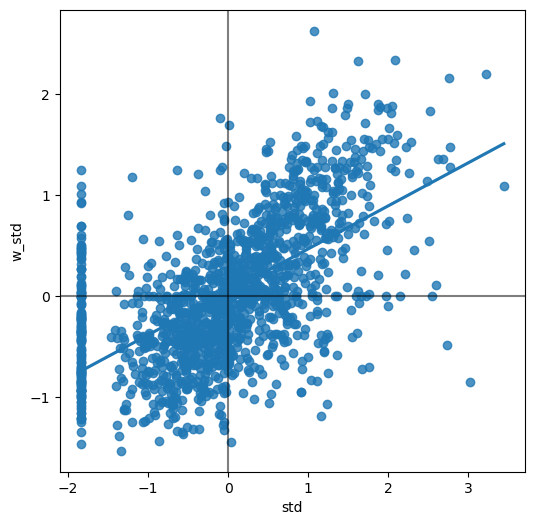

In [36]:
from pysal.lib import weights
df['std'] = (df['ev_rate_adj'] -df['ev_rate_adj'].mean()) / df['ev_rate_adj'].std()
df['w_std'] = weights.lag_spatial(w, df['std'])
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(x='std', y='w_std', data=df, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

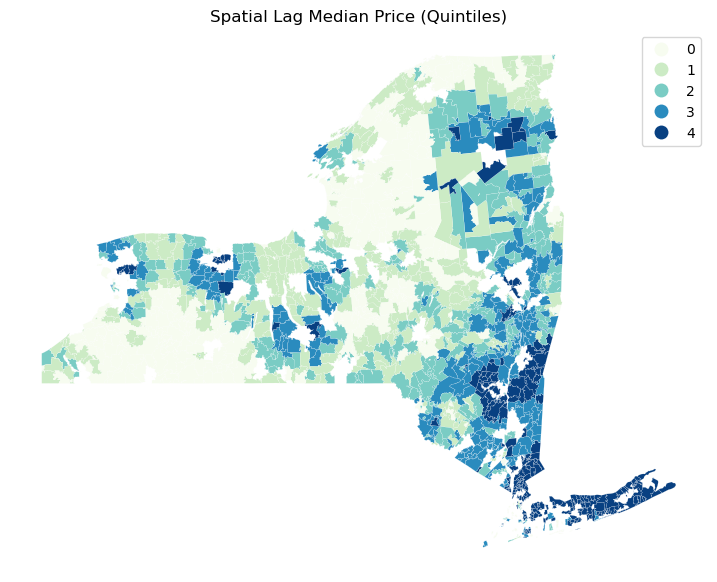

In [37]:
y = inp['ev_rate_adj']
ylag = libpysal.weights.lag_spatial(w, y)
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Price (Quintiles)")

plt.show()

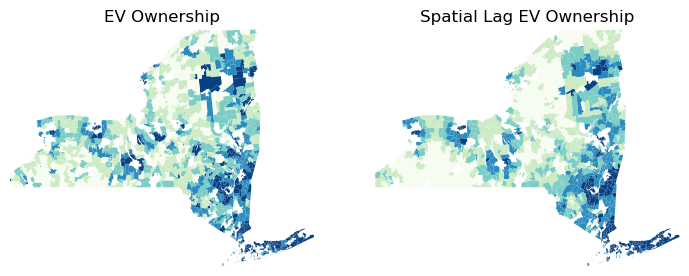

In [38]:
inp['lag_ev'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
inp.plot(column='ev_rate_adj', ax=ax[0], edgecolor=(1, 1, 1, 0),
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(inp.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("EV Ownership")
inp.plot(column='lag_ev', ax=ax[1], edgecolor=(1, 1, 1, 0),
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag EV Ownership")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [39]:
# y = inp['ev_rate_adj']
# ylag = libpysal.weights.lag_spatial(w, y)
# inp['lag_ev'] = ylag
# inp.to_file('ylag.shp')

# spatial lag
https://pysal.org/spreg/generated/spreg.ML_Lag.html

In [92]:
w = libpysal.weights.Queen.from_dataframe(inp)
w.transform = 'r'

('WARNING: ', 57, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 101, ' is an island (no neighbors)')
('WARNING: ', 126, ' is an island (no neighbors)')
('WARNING: ', 180, ' is an island (no neighbors)')
('WARNING: ', 216, ' is an island (no neighbors)')
('WARNING: ', 280, ' is an island (no neighbors)')
('WARNING: ', 309, ' is an island (no neighbors)')
('WARNING: ', 326, ' is an island (no neighbors)')
('WARNING: ', 347, ' is an island (no neighbors)')
('WARNING: ', 515, ' is an island (no neighbors)')
('WARNING: ', 591, ' is an island (no neighbors)')
('WARNING: ', 622, ' is an island (no neighbors)')
('WARNING: ', 628, ' is an island (no neighbors)')
('WARNING: ', 629, ' is an island (no neighbors)')
('WARNING: ', 649, ' is an island (no neighbors)')
('WARNING: ', 661, ' is an island (no neighbors)')
('WARNING: ', 663, ' is an island (no neighbors)')
('WARNING: ', 679, ' is an island (no neighbors)')
('WARNING: ', 680, ' is an island

In [93]:
df = inp.copy()
# dropped = [] # ,'D2A_EPHHM','D3APO','D5BR'
# df = df.drop(columns=dropped)
# cols = list(filter(lambda x: x not in dropped, inp_var))
# w = libpysal.weights.Queen.from_dataframe(df)
# w.transform = 'r'
X = df[inp_var]
X = X.values
y = df['ev_rate_adj']
y = y.values.reshape((-1,1))

min_max_scaler = preprocessing.MinMaxScaler()
scaled_X = min_max_scaler.fit_transform(X)

# Fit a spatial lag model
lag_model = ML_Lag(y, scaled_X, w, name_y='ev_rate_adj', name_x=inp_var) # , name_w='nys.gal', name_ds='columbus.dbf'
print(lag_model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : ev_rate_adj                Number of Observations:        1422
Mean dependent var  :      1.4674                Number of Variables   :          10
S.D. dependent var  :      0.7982                Degrees of Freedom    :        1412
Pseudo R-squared    :      0.4078
Spatial Pseudo R-squared:  0.3854
Sigma-square ML     :       0.377                Log likelihood        :   -1332.589
S.E of regression   :       0.614                Akaike info criterion :    2685.178
                                                 Schwarz criterion     :    2737.777

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [94]:
lag_model.z_stat

[(-0.045580883059056415, 0.963644306442322),
 (3.094512825321536, 0.001971364113020312),
 (11.946627595167278, 6.761361638317006e-33),
 (-3.1467005921930804, 0.0016512395392583178),
 (1.6443449645229673, 0.10010496635132242),
 (1.4667468629351725, 0.14244492949698456),
 (-1.9085511691591532, 0.05632001629295812),
 (4.690658261274332, 2.7232749119279013e-06),
 (6.483425213300697, 8.966333276191332e-11),
 (8.008970662242016, 1.156724963653136e-15)]

In [95]:
intercept = lag_model.betas[0]
coefficients = lag_model.betas[1:-1]
ylag = libpysal.weights.lag_spatial(w, y)

predy_train = intercept + scaled_X.dot(coefficients) + lag_model.betas[-1]*ylag
predy_train

array([[1.12573826],
       [2.13304343],
       [1.4415927 ],
       ...,
       [0.9552679 ],
       [1.14599542],
       [1.3902972 ]])

In [96]:
lag_model.predy

array([[1.12573826],
       [2.13304343],
       [1.4415927 ],
       ...,
       [0.9552679 ],
       [1.14599542],
       [1.3902972 ]])

In [97]:
mi = Moran(lag_model.u, w, two_tailed=False)
pd.Series(index=['Morans I','Z-Score','P-Value'],data=[mi.I, mi.z_norm, mi.p_norm])

Morans I    0.002761
Z-Score     0.178740
P-Value     0.429071
dtype: float64

In [99]:
df = scaled_inp.copy()
dropped = []
df = df.drop(columns=dropped)
cols = list(filter(lambda x: x not in dropped, inp_var))

# Initialize lists to store MAE for each fold
train_maes = []
test_maes = []

for i in range(5):
    # Split the data into a training set (80%) and a test set (20%)
   
    df_train, df_test = train_test_split(df, test_size=0.25, random_state=i)
    
    X_train = df_train[cols]
    y_train = df_train['ev_rate_adj']
    X_test = df_test[cols]
    y_test = df_test['ev_rate_adj']
    
    # Assuming you have defined 'intercept' and 'coefficients' elsewhere
    w = libpysal.weights.Queen.from_dataframe(df_train)
    w.transform = 'r'
    lag_model = ML_Lag(y_train.values.reshape((-1,1)), X_train.values, w, name_y='ev_rate_adj', name_x=cols)
    
    intercept = lag_model.betas[0]
    coefficients = lag_model.betas[1:-1]
    lambd = lag_model.betas[-1]

    # Calculate predictions
    ylag = libpysal.weights.lag_spatial(w, y_train).reshape(-1,1)
    predy_train = intercept + X_train.dot(coefficients) + lambd*ylag

    w = libpysal.weights.Queen.from_dataframe(df_test)
    w.transform = 'r'
    ylag = libpysal.weights.lag_spatial(w, y_test).reshape(-1,1)
    predy_test = intercept + X_test.dot(coefficients) + lambd*ylag

    # Calculate MAE for the current fold
    mae_train = mean_absolute_error(y_train, predy_train)
    mae_test = mean_absolute_error(y_test, predy_test)

    # Append MAE values to the lists
    train_maes.append(mae_train)
    test_maes.append(mae_test)

# Now you have lists 'train_maes' and 'test_maes' containing the MAE values for each fold
print("Train MAEs:", train_maes)
print("Test MAEs:", test_maes)
print("mean train MAE",np.mean(train_maes))
print("mean test MAE",np.mean(test_maes))

('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 25, ' is an island (no neighbors)')
('WARNING: ', 27, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 75, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 92, ' is an island (no neighbors)')
('WARNING: ', 137, ' is an island (no neighbors)')
('WARNING: ', 207, ' is an island (no neighbors)')
('WARNING: ', 223, ' is an island (no neighbors)')
('WARNING: ', 233, ' is an island (no neighbors)')
('WARNING: ', 248, ' is an island (no neighbors)')
('WARNING: ', 257, ' is an island (no neighbors)')
('WARNING: ', 262, ' is an island (no neighbors)')
('WARNING: ', 278, ' is an island (no neighbors)')
('WARNING: ', 290, ' is an island (no neighbors)')
('WARNING: ', 299, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no ne

# Spatial error

In [100]:
w = libpysal.weights.Queen.from_dataframe(inp)
w.transform = 'r'

('WARNING: ', 57, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 101, ' is an island (no neighbors)')
('WARNING: ', 126, ' is an island (no neighbors)')
('WARNING: ', 180, ' is an island (no neighbors)')
('WARNING: ', 216, ' is an island (no neighbors)')
('WARNING: ', 280, ' is an island (no neighbors)')
('WARNING: ', 309, ' is an island (no neighbors)')
('WARNING: ', 326, ' is an island (no neighbors)')
('WARNING: ', 347, ' is an island (no neighbors)')
('WARNING: ', 515, ' is an island (no neighbors)')
('WARNING: ', 591, ' is an island (no neighbors)')
('WARNING: ', 622, ' is an island (no neighbors)')
('WARNING: ', 628, ' is an island (no neighbors)')
('WARNING: ', 629, ' is an island (no neighbors)')
('WARNING: ', 649, ' is an island (no neighbors)')
('WARNING: ', 661, ' is an island (no neighbors)')
('WARNING: ', 663, ' is an island (no neighbors)')
('WARNING: ', 679, ' is an island (no neighbors)')
('WARNING: ', 680, ' is an island

In [101]:
df = inp.copy()

X = df[inp_var]
X = X.values
y = df['ev_rate_adj']
y = y.values.reshape((-1,1))
min_max_scaler = preprocessing.MinMaxScaler()
scaled_X = min_max_scaler.fit_transform(X)

error_model = ML_Error(y, scaled_X, w, name_y='ev_rate_adj', name_x=inp_var) # , name_w='nys.gal', name_ds='columbus.dbf'
print(error_model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : ev_rate_adj                Number of Observations:        1422
Mean dependent var  :      1.4674                Number of Variables   :           9
S.D. dependent var  :      0.7982                Degrees of Freedom    :        1413
Pseudo R-squared    :      0.3759
Sigma-square ML     :       0.380                Log likelihood        :   -1340.132
S.E of regression   :       0.616                Akaike info criterion :    2698.263
                                                 Schwarz criterion     :    2745.601

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [102]:
mi = Moran(error_model.u, w, two_tailed=False)
pd.Series(index=['Morans I','Z-Score','P-Value'],data=[mi.I, mi.z_norm, mi.p_norm])

Morans I    1.306417e-01
Z-Score     6.776130e+00
P-Value     6.171889e-12
dtype: float64

In [103]:
from sklearn.model_selection import train_test_split
# Initialize lists to store MAE for each fold
train_maes = []
test_maes = []

for i in range(5):
    # Split the data into a training set (80%) and a test set (20%)
    df_train, df_test = train_test_split(scaled_inp, test_size=0.2, random_state=i)
    
    X_train = df_train[inp_var]
    y_train = df_train['ev_rate_adj']
    X_test = df_test[inp_var]
    y_test = df_test['ev_rate_adj']
    
    # Assuming you have defined 'intercept' and 'coefficients' elsewhere
    w = libpysal.weights.Queen.from_dataframe(df_train)
    w.transform = 'r'
    error_model = ML_Error(y_train.values.reshape((-1,1)), X_train.values, w, name_y='ev_rate_adj', name_x=inp_var)
    intercept = error_model.betas[0]
    coefficients = error_model.betas[1:-1]

    # Calculate predictions
    predy_train = intercept + X_train.dot(coefficients)
    predy_test = intercept + X_test.dot(coefficients)

    # Calculate MAE for the current fold
    mae_train = mean_absolute_error(y_train, predy_train)
    mae_test = mean_absolute_error(y_test, predy_test)

    # Append MAE values to the lists
    train_maes.append(mae_train)
    test_maes.append(mae_test)

# Now you have lists 'train_maes' and 'test_maes' containing the MAE values for each fold
print("Train MAEs:", train_maes)
print("Test MAEs:", test_maes)
print("mean train MAE",np.mean(train_maes))
print("mean test MAE",np.mean(test_maes))

('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 59, ' is an island (no neighbors)')
('WARNING: ', 82, ' is an island (no neighbors)')
('WARNING: ', 93, ' is an island (no neighbors)')
('WARNING: ', 96, ' is an island (no neighbors)')
('WARNING: ', 98, ' is an island (no neighbors)')
('WARNING: ', 101, ' is an island (no neighbors)')
('WARNING: ', 120, ' is an island (no neighbors)')
('WARNING: ', 146, ' is an island (no neighbors)')
('WARNING: ', 163, ' is an island (no neighbors)')
('WARNING: ', 208, ' is an island (no neighbors)')
('WARNING: ', 278, ' is an island (no neighbors)')
('WARNING: ', 294, ' is an island (no neighbors)')
('WARNING: ', 304, ' is an island (no neighbors)')
('WARNING: ', 319, ' is an island (no neighbors)')
('WARNING: ', 328, ' is an island (no neighbors)')
('WARNING: ', 349, ' is an island (no neighbors)')
('WARNING: ', 370, ' is an island (no neighbors)')
('WARNING: ', 373, ' is an island (no neighbors)')
('WARNING: ', 384, ' is an island (no

# GWR

https://mgwr.readthedocs.io/en/latest/generated/mgwr.gwr.GWRResults.html

In [104]:
w = libpysal.weights.Queen.from_dataframe(inp)
w.transform = 'r'

('WARNING: ', 57, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 101, ' is an island (no neighbors)')
('WARNING: ', 126, ' is an island (no neighbors)')
('WARNING: ', 180, ' is an island (no neighbors)')
('WARNING: ', 216, ' is an island (no neighbors)')
('WARNING: ', 280, ' is an island (no neighbors)')
('WARNING: ', 309, ' is an island (no neighbors)')
('WARNING: ', 326, ' is an island (no neighbors)')
('WARNING: ', 347, ' is an island (no neighbors)')
('WARNING: ', 515, ' is an island (no neighbors)')
('WARNING: ', 591, ' is an island (no neighbors)')
('WARNING: ', 622, ' is an island (no neighbors)')
('WARNING: ', 628, ' is an island (no neighbors)')
('WARNING: ', 629, ' is an island (no neighbors)')
('WARNING: ', 649, ' is an island (no neighbors)')
('WARNING: ', 661, ' is an island (no neighbors)')
('WARNING: ', 663, ' is an island (no neighbors)')
('WARNING: ', 679, ' is an island (no neighbors)')
('WARNING: ', 680, ' is an island

In [105]:
X = inp[inp_var]
y = inp['ev_rate_adj'].values.reshape((-1,1))
min_max_scaler = preprocessing.MinMaxScaler()
scaled_X = min_max_scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns=X.columns)

u = inp.centroid.map(lambda p: p.x)
v = inp.centroid.map(lambda p: p.y)
coords = list(zip(u,v))

gwr_selector = Sel_BW(coords, y, scaled_X.values)
gwr_bw = gwr_selector.search(bw_min=2)
gwr_model = GWR(coords, y, scaled_X.values, gwr_bw, kernel='gaussian')
gwr_results = gwr_model.fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                1422
Number of covariates:                                                     9

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            564.409
Log-likelihood:                                                   -1360.737
AIC:                                                               2739.475
AICc:                                                              2741.631
BIC:                                                              -9693.716
R2:                                                                   0.377
Adj. R2:                                                              0.373

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [106]:
# gwr_w = weights.distance.Kernel.from_array(coords, fixed=False)
mi = esda.moran.Moran(gwr_results.resid_response.reshape((-1,1)), w,  two_tailed=False)
pd.Series(index=['Morans I','Z-Score','P-Value'],data=[mi.I, mi.z_norm, mi.p_norm])

Morans I    0.077031
Z-Score     4.010349
P-Value     0.000030
dtype: float64

In [107]:
from sklearn.model_selection import train_test_split
# Initialize lists to store MAE for each fold
train_maes = []
test_maes = []

for i in range(5):
    # Split the data into a training set (80%) and a test set (20%)
    df_train, df_test = train_test_split(scaled_inp, test_size=0.25, random_state=i)
    
    X_train = df_train[inp_var]
    y_train = df_train['ev_rate_adj']
    X_test = df_test[inp_var]
    y_test = df_test['ev_rate_adj']
    
    u = df_train.centroid.map(lambda p: p.x)
    v = df_train.centroid.map(lambda p: p.y)
    coords = np.array(list(zip(u,v)))

    gwr_selector = Sel_BW(coords, y_train.values.reshape((-1,1)), X_train.values)
    gwr_bw = gwr_selector.search(bw_min=2)
    gwr_model = GWR(coords,y_train.values.reshape((-1,1)), X_train.values, gwr_bw, kernel='gaussian')
    gwr_results = gwr_model.fit()

    scale = gwr_results.scale
    residuals = gwr_results.resid_response

    predy_train = gwr_model.predict(coords, X_train.values, scale, residuals).predictions

    u = df_test.centroid.map(lambda p: p.x)
    v = df_test.centroid.map(lambda p: p.y)
    pred_coords = np.array(list(zip(u,v)))
    predy_test = gwr_model.predict(pred_coords, X_test, scale, residuals).predictions

    # Calculate MAE for the current fold
    mae_train = mean_absolute_error(y_train, predy_train)
    mae_test = mean_absolute_error(y_test, predy_test)

    # Append MAE values to the lists
    train_maes.append(mae_train)
    test_maes.append(mae_test)

# Now you have lists 'train_maes' and 'test_maes' containing the MAE values for each fold
print("Train MAEs:", train_maes)
print("Test MAEs:", test_maes)
print("mean train MAE",np.mean(train_maes))
print("mean test MAE",np.mean(test_maes))

Train MAEs: [0.45084871041135655, 0.43188312533633166, 0.42382905327967735, 0.44663194018801866, 0.42866424030761646]
Test MAEs: [0.4188943008292633, 0.4598279157469421, 0.4776148628843502, 0.4314977846990783, 0.46455183471397526]
mean train MAE 0.4363714139046001
mean test MAE 0.4504773397747218


In [108]:
# gwr_weights = pd.DataFrame(gwr_results.params,columns = ['intercept']+inp_var)
# # gwr_weights['localR2'] = gwr_results.localR2
# tvalue = pd.DataFrame(gwr_results.filter_tvals(alpha=0.15),columns = ['t_' + iterator for iterator in ['intercept']+inp_var])
# gwr_weights = pd.concat([gwr_weights, tvalue], axis=1)
# print(len(gwr_weights))
# gwr_weights = pd.concat([gwr_weights, inp[['geometry']]], axis=1)

# # remove insignificant variables
# # weights = weights[weights.localR2>=0.25]
# print(len(gwr_weights))
# gwr_weights = gpd.GeoDataFrame(gwr_weights, geometry=inp.geometry)
# gwr_weights.head(2)
# gwr_weights.to_file('gwr_weights.shp')

# gwr_weights[['t_' + iterator for iterator in ['intercept']+inp_var]].describe()

In [109]:
# len(gwr_weights[np.abs(gwr_weights.t_intercept)>1.69])/len(gwr_weights)*100

# Results Summary

In [41]:
X = inp[inp_var].values
y = inp['ev_rate_adj'].values.reshape((-1,1))
min_max_scaler = preprocessing.MinMaxScaler()
scaled_X = min_max_scaler.fit_transform(X)

# OLS
X_ols = sm.add_constant(scaled_X)
ols_model = sm.OLS(y, X_ols)
ols_results = ols_model.fit()

# Lag
lag_model = ML_Lag(y, scaled_X, w, name_y='ev_rate_adj', name_x=inp_var) # , name_w='nys.gal', name_ds='columbus.dbf'

# Error
error_model = ML_Error(y, scaled_X, w, name_y='ev_rate_adj', name_x=inp_var) # , name_w='nys.gal', name_ds='columbus.dbf'

# GWR
u = inp.centroid.map(lambda p: p.x)
v = inp.centroid.map(lambda p: p.y)
coords = list(zip(u,v))
gwr_selector = Sel_BW(coords, y, scaled_X)
gwr_bw = gwr_selector.search(bw_min=2)
gwr_model = GWR(coords, y, scaled_X, gwr_bw, kernel='gaussian')
gwr_results = gwr_model.fit()

In [42]:
# Extract coefficients and standard errors from the models
ols_coefficients = ols_results.params
ols_std = ols_results.bse  # Standard errors

lag_coefficients = lag_model.betas[0:-1]  # Exclue  last
lag_std = lag_model.std_err[0:-1]  # Standard errors

error_coefficients = error_model.betas[0:-1]  # Coefficients
error_std = error_model.std_err[0:-1]  # Standard errors

gwr_coefficients = np.mean(gwr_results.params, axis=0)
gwr_std = np.mean(gwr_results.bse, axis=0)  # Standard errors

# Create a DataFrame to store the results
df = pd.DataFrame({'variable':['constant','% older people','% Bachelor degree of higher','Rent proportion',
                                    'Low speed network density','Employment and household entropy','Transit accessible jobs',
                                    'Housing cost/income','Charging stations'],
                        'ols_coefficient': ols_coefficients,
                        'ols_std': ols_std,
                        'gwr_coefficient': gwr_coefficients,
                        'gwr_std': gwr_std,
                        'lag_coefficient': np.squeeze(lag_coefficients),
                        'lag_std': lag_std,
                        'error_coefficient': np.squeeze(error_coefficients),
                        'error_std': error_std,
                        })
# df.to_csv('results_v2.csv')
df

,variable,ols_coefficient,ols_std,gwr_coefficient,gwr_std,lag_coefficient,lag_std,error_coefficient,error_std
0,constant,0.062349,0.105823,0.220971,0.132817,-0.004713,0.103390,0.157152,0.113281
1,% older people,0.542919,0.157577,0.525924,0.189777,0.473811,0.153113,0.450813,0.155885
2,% Bachelor degree of higher,1.540077,0.111623,1.396041,0.135596,1.323467,0.110782,1.413528,0.115829
3,Rent proportion,-0.511921,0.121662,-0.485450,0.148830,-0.373534,0.118706,-0.389149,0.125879
4,Low speed network density,0.299937,0.145164,0.253025,0.182106,0.232144,0.141177,0.227460,0.156658
5,Employment and household entropy,0.309407,0.151225,0.282663,0.188001,0.215975,0.147248,0.288750,0.153368
6,Transit accessible jobs,-0.120199,0.050284,-0.108468,0.063838,-0.093371,0.048922,-0.089413,0.055169
7,Housing cost/income,0.946753,0.167527,0.762645,0.210520,0.770463,0.164255,0.866004,0.177464
8,Charging stations,0.655395,0.075972,0.675894,0.093610,0.494614,0.076289,0.617114,0.087521


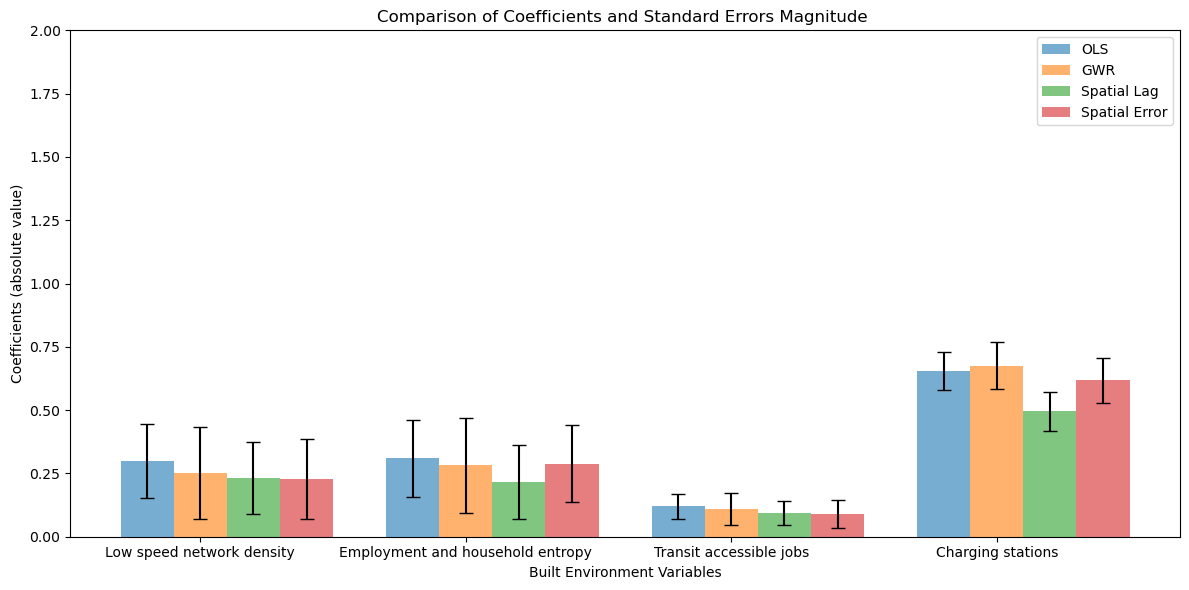

In [43]:
results = df[df.variable.isin(['Low speed network density','Employment and household entropy','Transit accessible jobs','Charging stations'])]
# Plot the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2  # Width of each bar
index = np.arange(len(results))  # X-axis values

# Plot bars for OLS coefficients and their standard deviations
ax.bar(index, np.abs(results['ols_coefficient']), bar_width, label='OLS', yerr=results['ols_std'],
       align='center', alpha=0.6, capsize=5)

# Plot bars for GWR coefficients and their standard deviations
ax.bar(index + bar_width, np.abs(results['gwr_coefficient']), bar_width, label='GWR', yerr=results['gwr_std'],
       align='center', alpha=0.6, capsize=5)

# Plot bars for Lag coefficients and their standard deviations
ax.bar(index + 2 * bar_width, np.abs(results['lag_coefficient']), bar_width, label='Spatial Lag', yerr=results['lag_std'],
       align='center', alpha=0.6, capsize=5)

# Plot bars for Error coefficients and their standard deviations
ax.bar(index + 3 * bar_width, np.abs(results['error_coefficient']), bar_width, label='Spatial Error', yerr=results['error_std'],
       align='center', alpha=0.6, capsize=5)
plt.ylim(0,2)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(results['variable'], rotation=0)
ax.set_xlabel('Built Environment Variables')
ax.set_ylabel('Coefficients (absolute value)')
ax.set_title('Comparison of Coefficients and Standard Errors Magnitude ')
ax.legend()

plt.tight_layout()
plt.show()

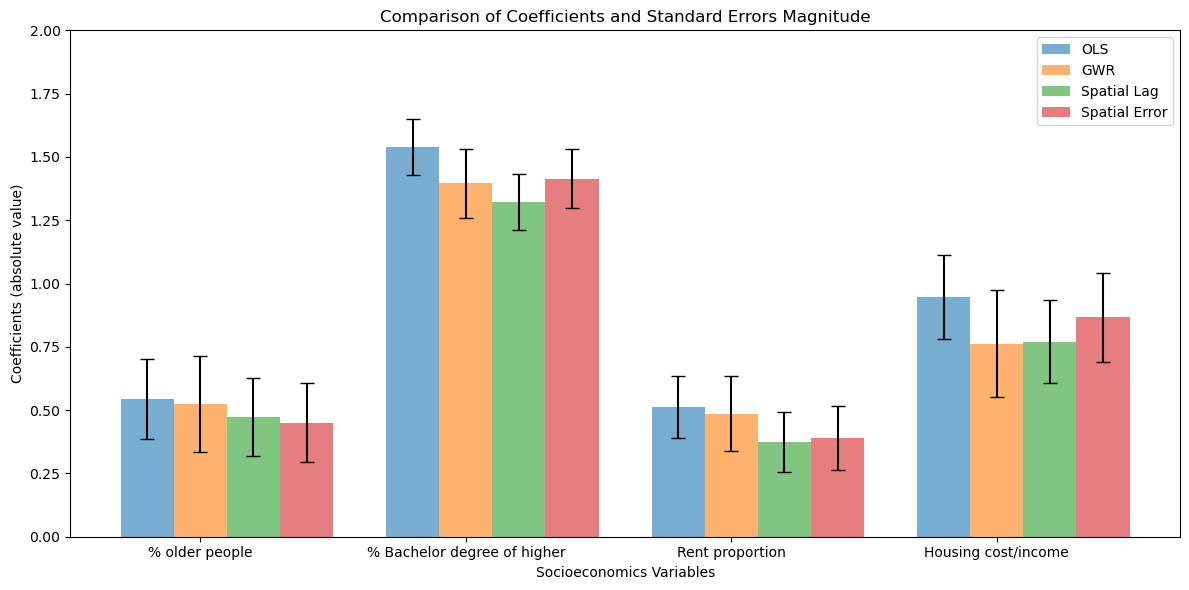

In [44]:
results = df[df.variable.isin(['% older people','% Bachelor degree of higher','Rent proportion','Housing cost/income'])]
# Plot the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2  # Width of each bar
index = np.arange(len(results))  # X-axis values

# Plot bars for OLS coefficients and their standard deviations
ax.bar(index, np.abs(results['ols_coefficient']), bar_width, label='OLS', yerr=results['ols_std'],
       align='center', alpha=0.6, capsize=5)

# Plot bars for GWR coefficients and their standard deviations
ax.bar(index + bar_width, np.abs(results['gwr_coefficient']), bar_width, label='GWR', yerr=results['gwr_std'],
       align='center', alpha=0.6, capsize=5)

# Plot bars for Lag coefficients and their standard deviations
ax.bar(index + 2 * bar_width, np.abs(results['lag_coefficient']), bar_width, label='Spatial Lag', yerr=results['lag_std'],
       align='center', alpha=0.6, capsize=5)

# Plot bars for Error coefficients and their standard deviations
ax.bar(index + 3 * bar_width, np.abs(results['error_coefficient']), bar_width, label='Spatial Error', yerr=results['error_std'],
       align='center', alpha=0.6, capsize=5)
plt.ylim(0,2)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(results['variable'], rotation=0)
ax.set_xlabel('Socioeconomics Variables')
ax.set_ylabel('Coefficients (absolute value)')
ax.set_title('Comparison of Coefficients and Standard Errors Magnitude')
ax.legend()

plt.tight_layout()
plt.show()